In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### 1. 导入数据集

In [76]:
path = "../Data/exercise_data/chipotle.tsv"

# tsv的数据用\t作为分隔符
df = pd.read_csv(path, sep='\t')

### 2.查看基本信息

In [3]:
df.head()

,order_id,quantity,item_name,choice_description,item_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,$2.39
1,1,1,Izze,[Clementine],$3.39
2,1,1,Nantucket Nectar,[Apple],$3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,$2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",$16.98


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4622 entries, 0 to 4621
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_id            4622 non-null   int64 
 1   quantity            4622 non-null   int64 
 2   item_name           4622 non-null   object
 3   choice_description  3376 non-null   object
 4   item_price          4622 non-null   object
dtypes: int64(2), object(3)
memory usage: 180.7+ KB


### 2.1 数据字段梳理

该样本数据集为Chipotle快餐厅数据，包含5列信息
+ `order_id`:订单编号
+ `quantity`:购买数量
+ `item_name`:商品名称
+ `choice_description`:选择描述，应是订单中的配料选择记录
+ `item_price`:商品价格

### 2.2 缺失数据确认

In [5]:
missing = df.isnull().sum() / len(df)
missing

order_id              0.00000
quantity              0.00000
item_name             0.00000
choice_description    0.26958
item_price            0.00000
dtype: float64

`choice_description`项有26.96%的数据缺失

## 3. 数据预处理

在查看基本信息的过程中，我们注意到`item_price`的类型为`object`，由于该字段为金额，所以我们将其转化为浮点数

In [6]:
df.item_price = df.item_price.str.replace('$', '').astype(float)
df.head()

,order_id,quantity,item_name,choice_description,item_price
0,1,1,Chips and Fresh Tomato Salsa,NaN,2.39
1,1,1,Izze,[Clementine],3.39
2,1,1,Nantucket Nectar,[Apple],3.39
3,1,1,Chips and Tomatillo-Green Chili Salsa,NaN,2.39
4,2,2,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Black Beans...",16.98


## 4.探索性分析

### 问题：

1. 一共有多少种商品出售
2. 销量最高的前5类商品
3. 销售额最高的前5类商品
4. 配料中需求量最大的5类商品
5. 平均每笔订单的金额是多少

### 4.1 一共有多少种商品出售？

In [7]:
len(df.item_name.unique())

50

一共有五十种商品出售


### 4.2 销量最高的前5类商品
销量等于商品的销售数量之和

In [8]:
df.groupby('item_name').count().order_id.sort_values(ascending=False).head()

item_name
Chicken Bowl           726
Chicken Burrito        553
Chips and Guacamole    479
Steak Burrito          368
Canned Soft Drink      301
Name: order_id, dtype: int64

In [9]:
sales_quantity = df.groupby('item_name').quantity.sum().sort_values(ascending=False)
sales_quantity.head(5)

item_name
Chicken Bowl           761
Chicken Burrito        591
Chips and Guacamole    506
Steak Burrito          386
Canned Soft Drink      351
Name: quantity, dtype: int64

比较两项输出结果，后者的数值都高于前者，如果只统计商品名称次数的话会产生遗漏

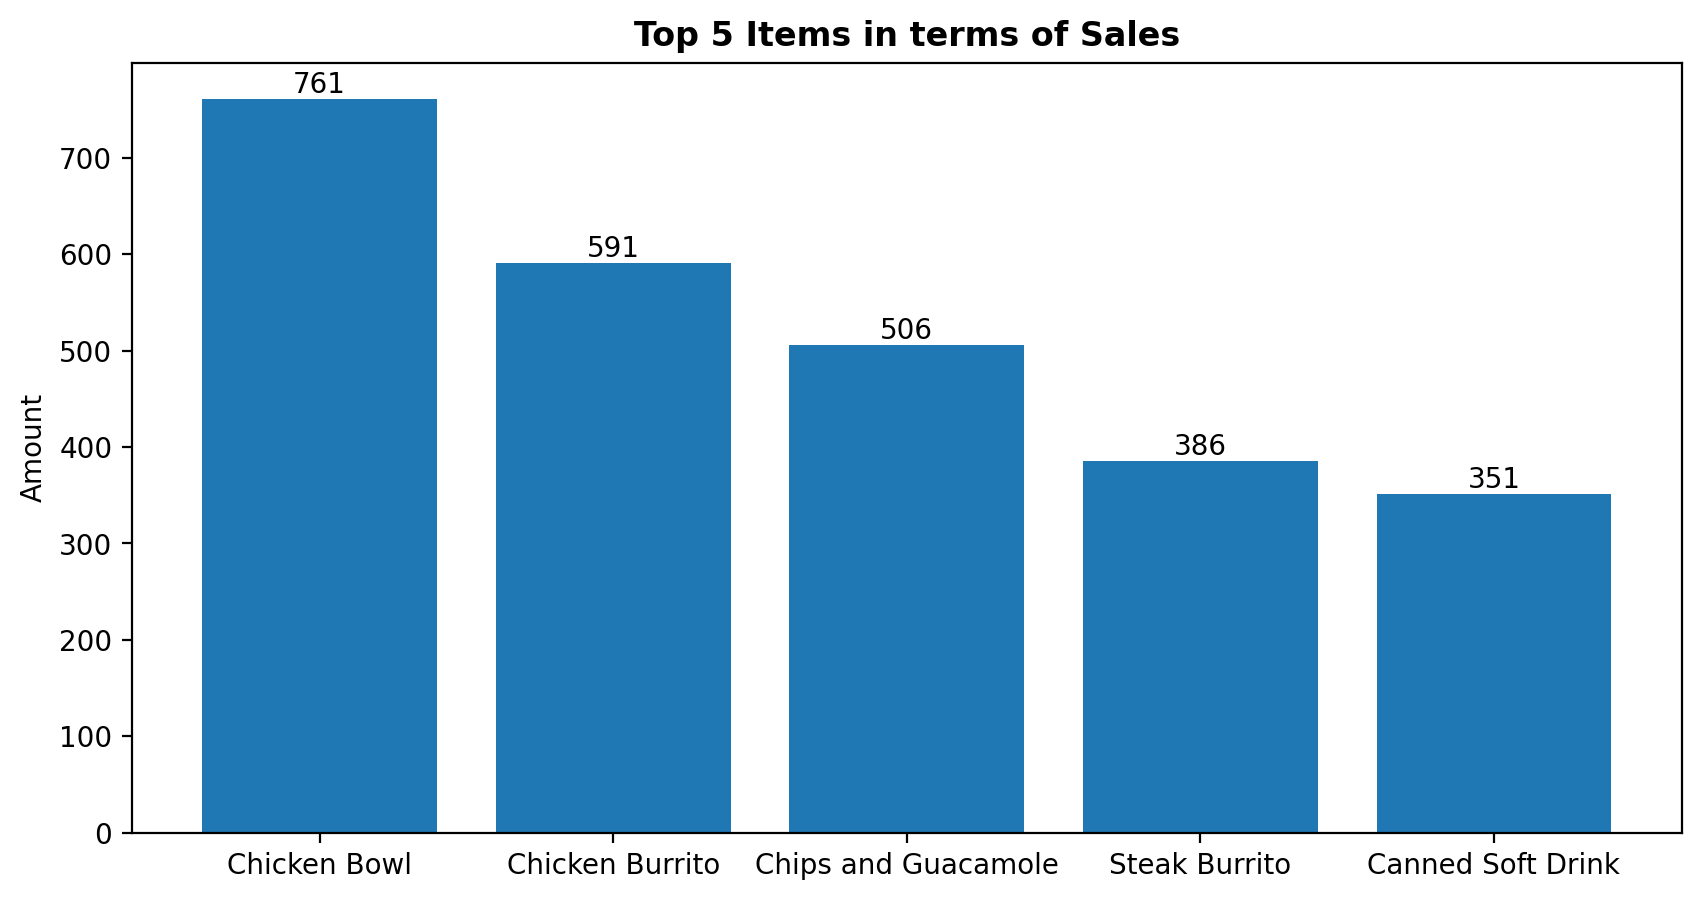

In [10]:
fig, ax = plt.subplots(figsize=(10,5), dpi=200)
bars = ax.bar(sales_quantity.head(5).index, sales_quantity.head(5))
ax.bar_label(bars)
plt.title('Top 5 Items in terms of Sales', fontweight='bold')
plt.ylabel("Amount")
plt.xticks(rotation=0)

plt.show();

In [11]:
#计算Chicken Bowl在总销量中的占比
f"{sales_quantity.loc['Chicken Bowl'] / sales_quantity.sum()*100:.2f}%"

'15.31%'

**结论**：Chicken Bowl是卖得最好的商品，占总体销售量的15.31%

### 4.3 销售额最高的前5类商品

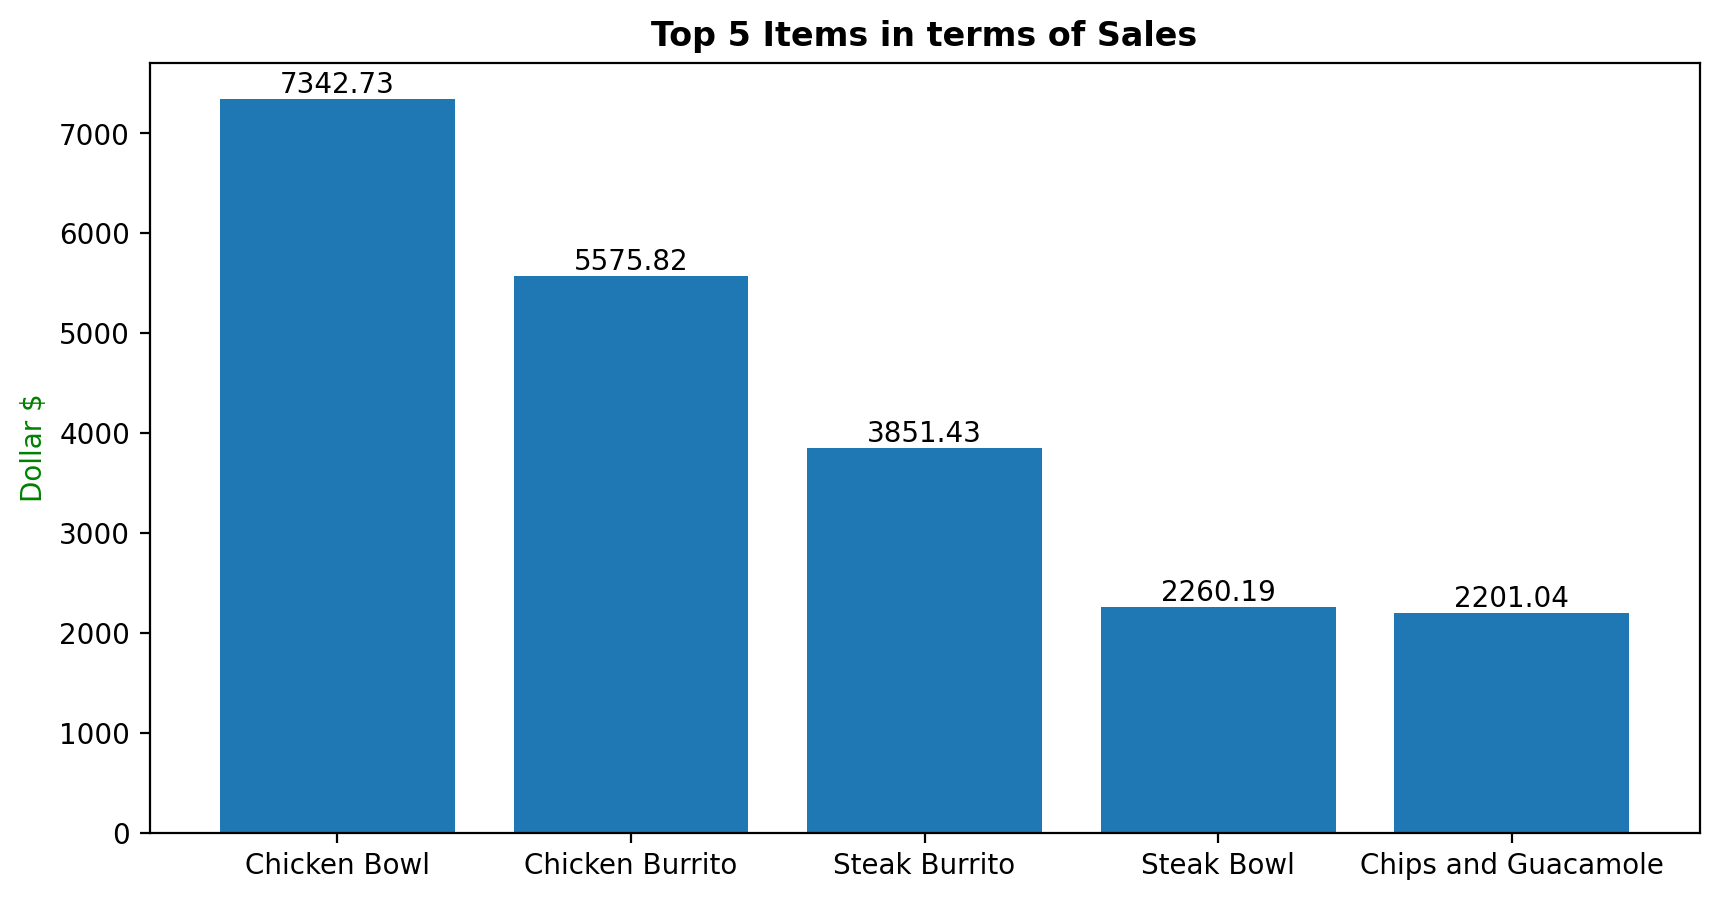

In [12]:
sales_income = df.groupby('item_name').item_price.sum().sort_values(ascending=False)

#绘出柱状图

fig, ax = plt.subplots(figsize=(10,5), dpi=200)
bars = ax.bar(sales_income.head(5).index, sales_income.head(5))
ax.bar_label(bars)
plt.title('Top 5 Items in terms of Sales', fontweight='bold')
plt.ylabel("Dollar $", color='g')
plt.xticks(rotation=0)

plt.show();

### 4.4 配料中的商品分析

由于每一项实例的备注包含了许多商品，我们需要对其进行规范化处理

In [13]:
import re
from collections import Counter

# 去除空白数据，并将该字段整合为列表
description = df.choice_description.dropna().tolist()

items = []
for entry in description:
    # 使用正则表达移除大括号，并用逗号分隔，去掉空格
    cleaned_items = re.sub(r'[\[\]]','',entry).split(',')
    stripped_items = [s.strip() for s in cleaned_items]
    items.extend(stripped_items)

# 使用Python自带函数Counter统计列表中各项的次数
item_counts = Counter(items)

description_items = pd.Series(item_counts).sort_values(ascending=False)

In [14]:
description_items

Rice                                    2389
Cheese                                  2281
Lettuce                                 1742
Sour Cream                              1711
Black Beans                             1342
Fresh Tomato Salsa                      1046
Guacamole                               1037
Fajita Vegetables                        722
Pinto Beans                              582
Roasted Chili Corn Salsa                 457
Fresh Tomato Salsa (Mild)                351
Tomatillo Red Chili Salsa                325
Fajita Veggies                           302
Roasted Chili Corn Salsa (Medium)        270
Tomatillo-Red Chili Salsa (Hot)          259
Tomatillo Green Chili Salsa              230
Diet Coke                                134
Tomatillo-Green Chili Salsa (Medium)     128
Coke                                     123
Sprite                                    77
Lemonade                                  33
Fresh Tomato (Mild)                       31
Coca Cola 

In [15]:
len(description_items)

46

备注中一共有46种商品出现

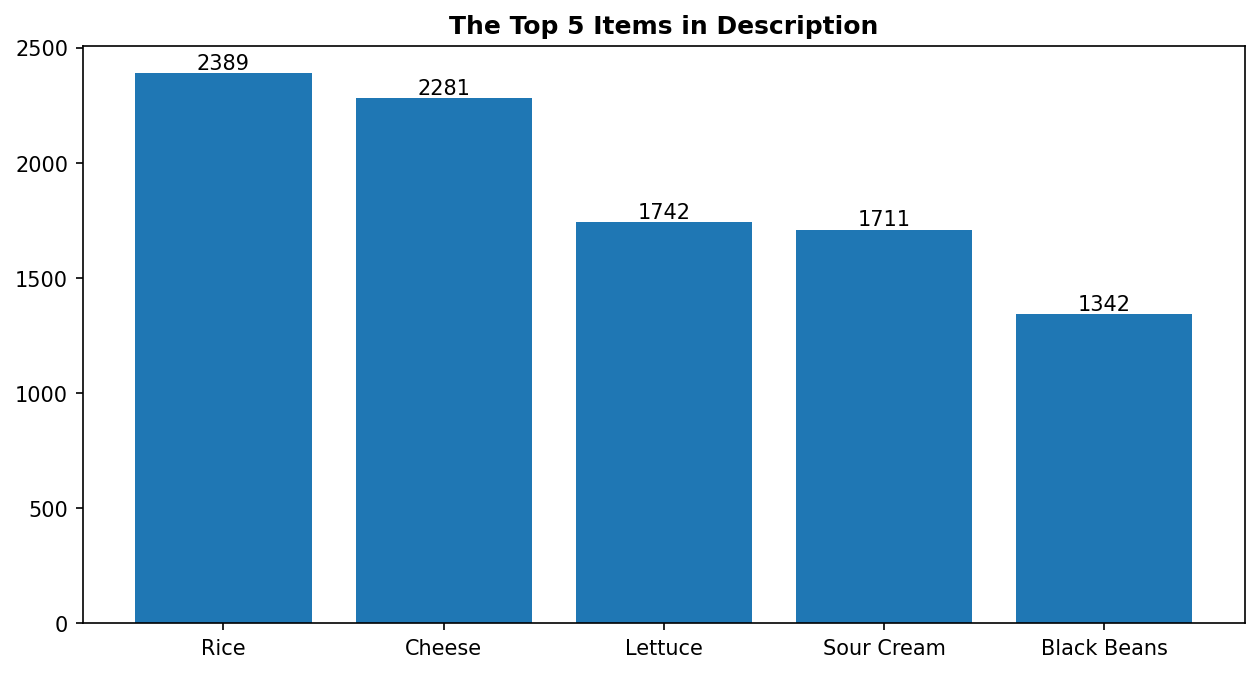

In [16]:
fig, ax = plt.subplots(figsize=(10,5), dpi=150)
bars = ax.bar(description_items.head(5).index, description_items.head(5))
ax.bar_label(bars)
plt.title('The Top 5 Items in Description', fontweight='bold')
plt.show()

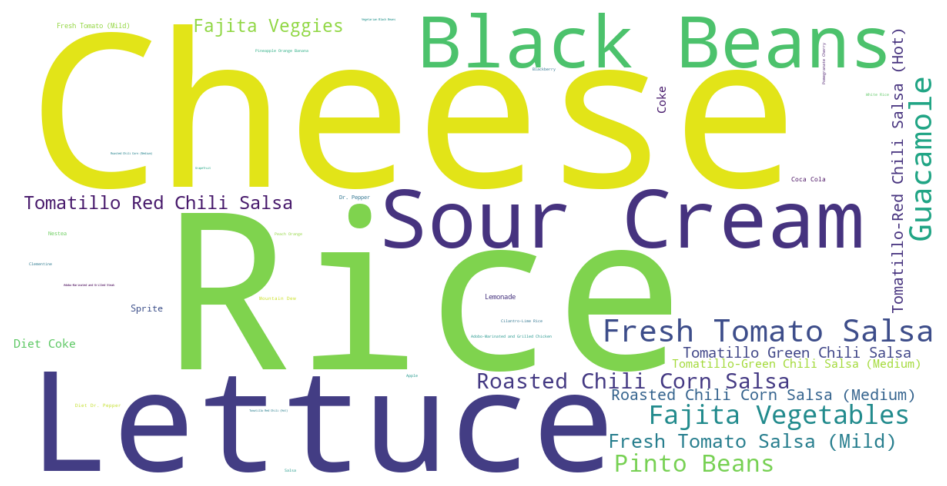

In [17]:
from wordcloud import WordCloud

# 创造字图
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(description_items)

# 用matplotlib画出字图
plt.figure(figsize=(10,5), dpi=120)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show();

我们再计算一下在配料选择非空白的订单中，各类热门配料的占比情况

In [18]:
ingredient_rate = (description_items / len(df.choice_description.dropna())).apply(lambda x: f"{x*100:.2f}%")
ingredient_rate

Rice                                    70.76%
Cheese                                  67.57%
Lettuce                                 51.60%
Sour Cream                              50.68%
Black Beans                             39.75%
Fresh Tomato Salsa                      30.98%
Guacamole                               30.72%
Fajita Vegetables                       21.39%
Pinto Beans                             17.24%
Roasted Chili Corn Salsa                13.54%
Fresh Tomato Salsa (Mild)               10.40%
Tomatillo Red Chili Salsa                9.63%
Fajita Veggies                           8.95%
Roasted Chili Corn Salsa (Medium)        8.00%
Tomatillo-Red Chili Salsa (Hot)          7.67%
Tomatillo Green Chili Salsa              6.81%
Diet Coke                                3.97%
Tomatillo-Green Chili Salsa (Medium)     3.79%
Coke                                     3.64%
Sprite                                   2.28%
Lemonade                                 0.98%
Fresh Tomato 

通过分析我们可以发现，大多数的顾客都会选择米饭，芝士，生菜，酸酱和黑豆作为配料，其中有记录的订单里，70%的顾客选择了米饭

使用ChatGPT对所有配料进行分析后，发现可选配料大致分为五类
+ 谷物和谷类食品
+ 乳制品
+ 蔬菜和豆类
+ 调味酱和沙司
+ 饮料

### 4.5 哪些商品搭配的配料比较多

In [19]:
df['choice_count'] =  df.choice_description.apply(lambda x: len(re.sub(r'[\[\]]','',x).split(',')) if isinstance(x, str) else 0)

In [20]:
df_items = df.groupby('item_name').sum().drop(['order_id','choice_description'], axis=1).sort_values(by='choice_count', ascending=False)
df_items['choices_per_item'] = df_items.choice_count / df_items.quantity
df_items.sort_values(by='choices_per_item', ascending=False)

,quantity,item_price,choice_count,choices_per_item
item_name,,,,
Veggie Salad,6,50.94,39,6.500000
Veggie Bowl,87,867.99,530,6.091954
Carnitas Salad,1,8.99,6,6.000000
Carnitas Bowl,71,736.71,417,5.873239
Veggie Burrito,97,934.77,566,5.835052
Carnitas Salad Bowl,6,66.34,35,5.833333
Burrito,6,44.40,35,5.833333
Veggie Salad Bowl,18,182.50,103,5.722222
Steak Bowl,221,2260.19,1189,5.380090


根据分析结果，Bowl, Salad, Tacos和Burrito是需要配料较多的餐品，其中肉馅沙拉、素食沙拉和素食碗所含有的配料平均在6种以上

### 4.6 平均每笔订单的价格

In [21]:
# 计算一共有多少笔订单
len(df.groupby('order_id').item_price.sum())

1834

数据集中一共有1834笔订单

In [22]:
# 总收入除以订单数，得到每笔订单的平均收入
df.item_price.sum() / 1834

18.811428571428575

每笔订单的平均价格为18.81美元

### 4.7 商品价格与配料的关系

选择所有数量为1的Chicken Bowl订单后，发现商品的价格不是一致的，最便宜为8.19$，最贵为11.25$

In [23]:
chiken_bowl_1 = df[(df['item_name'] == 'Chicken Bowl') & (df.quantity == 1)].sort_values('item_price')
chiken_bowl_1

,order_id,quantity,item_name,choice_description,item_price,choice_count
3664,1466,1,Chicken Bowl,"[Fresh Tomato (Mild), [Lettuce, Fajita Veggies...",8.19,7
2918,1160,1,Chicken Bowl,"[Fresh Tomato (Mild), [Rice, Sour Cream, Cheese]]",8.19,4
3101,1237,1,Chicken Bowl,"[Fresh Tomato (Mild), [Lettuce, Fajita Veggies...",8.19,7
934,385,1,Chicken Bowl,"[Fresh Tomato Salsa (Mild), [Pinto Beans, Rice...",8.49,6
937,386,1,Chicken Bowl,"[Tomatillo-Red Chili Salsa (Hot), [Rice, Fajit...",8.49,6
...,...,...,...,...,...,...
3655,1461,1,Chicken Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Rice,...",11.25,7
1629,657,1,Chicken Bowl,"[Fresh Tomato Salsa, [Rice, Fajita Vegetables,...",11.25,6
2646,1051,1,Chicken Bowl,"[Fresh Tomato Salsa, [Fajita Vegetables, Rice,...",11.25,7
765,316,1,Chicken Bowl,"[Roasted Chili Corn Salsa, [Fajita Vegetables,...",11.25,8


首先假设**商品的单价与选择配料的数量相关**，这里使用散点图来观察两者之间的关系

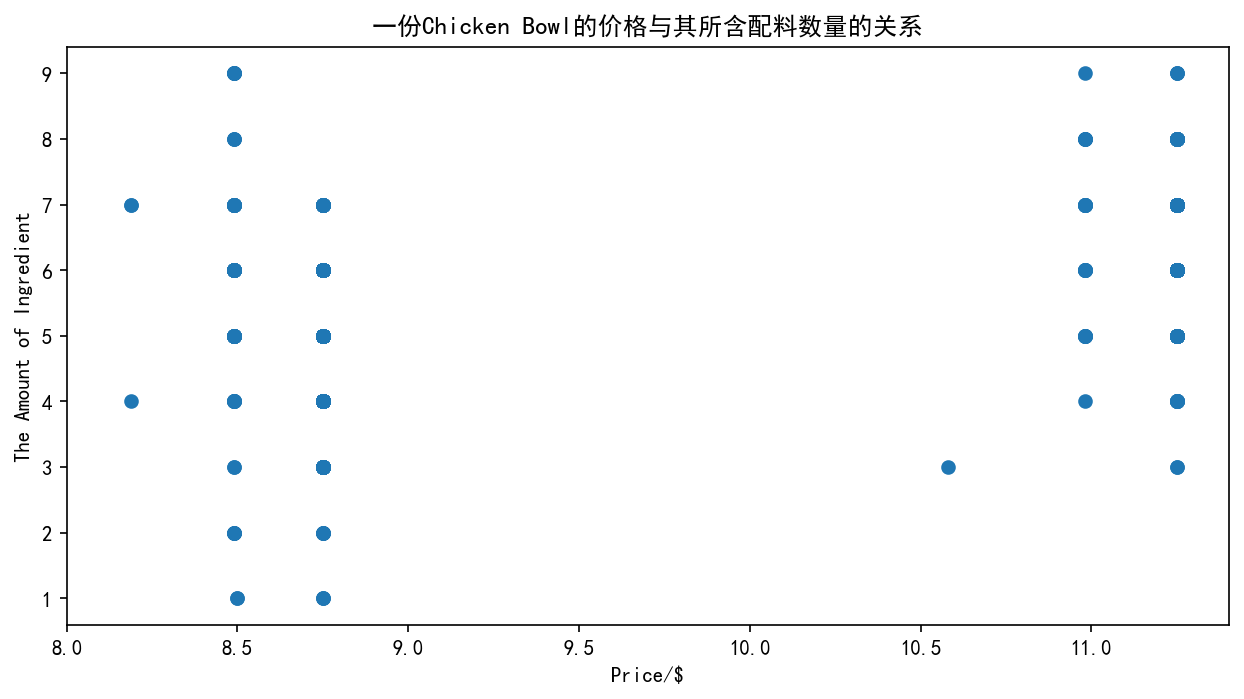

In [24]:
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

plt.figure(figsize=(10,5), dpi=150)
plt.scatter(chiken_bowl_1.item_price, chiken_bowl_1.choice_count)
plt.title('一份Chicken Bowl的价格与其所含配料数量的关系')
plt.xlabel("Price/$")
plt.ylabel("The Amount of Ingredient")
plt.xlim(8)
plt.show()

上图表明配料数量与商品的价格是无关的，在价格相同的情况下，订单的配料数量可能会有很大的差异。

为了检验配料与商品价格是否相关，我们检验是否存在配料相同但价格不同的情况

In [25]:
status = False
for description in chiken_bowl_1.choice_description.unique():
    temp = chiken_bowl_1[chiken_bowl_1['choice_description'] ==  description]
    if (len(temp) >= 2) & (temp.item_price.nunique() >= 2):
        print('存在配料相同但价格不同的情况')
        status = True
        break
        
if not status:
    print("不存在配料相同但价格不同的情况")

不存在配料相同但价格不同的情况


分析过后，发现配料确实影响了商品的价格，同一种商品，选择不同的配料，价格会不同。为了更好的判断哪些配料会影响Chicken Bowl的价格，我们可以使用机器学习模型来提取配料的特征，并用随机森林模型进行回归预测。此处由于description是文本信息，我们可以使用常见的Term Frequency-Inverse Document Frequency(TF-IDF)技术，将文本转化为矩阵。

Mean Absolute Error: 0.01
R2 Score: 1.00


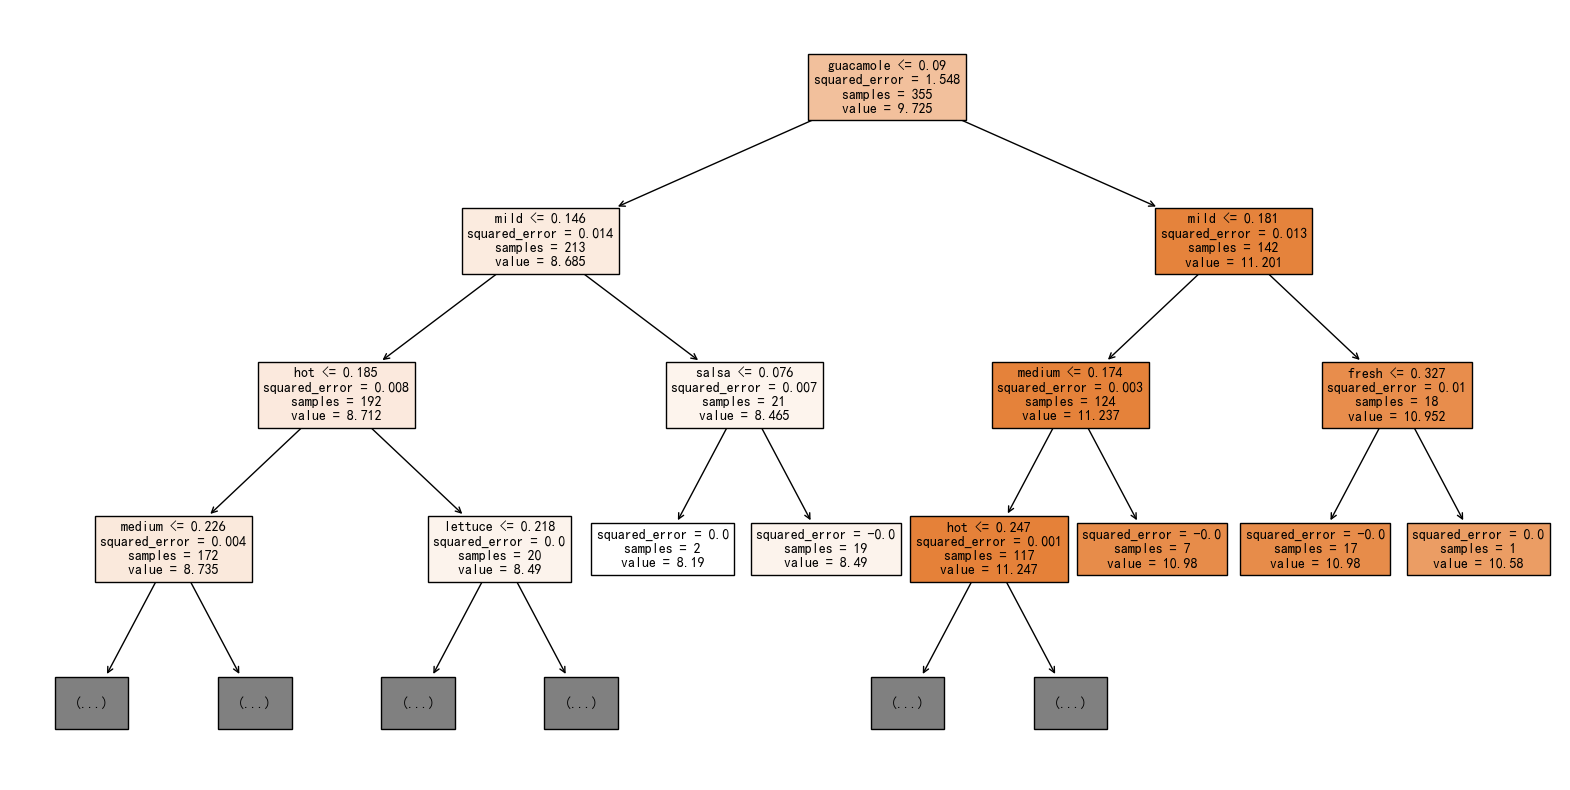

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_features=100)
X = tfidf_vectorizer.fit_transform(chiken_bowl_1.choice_description)

#Target variable
y = chiken_bowl_1.item_price

#Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#Predict the test data
y_pred = rf.predict(X_test)

#Evaluate the model
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

#Draw the tree diagram
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Get one of the trees from the Random Forest
single_tree = rf.estimators_[0]

# Set figure parameters for better visualization
plt.figure(figsize=(20, 10))
plot_tree(single_tree, feature_names=tfidf_vectorizer.get_feature_names_out().tolist(), max_depth=3, filled=True, fontsize=10)
plt.show()



平均方差为0.01，R2为1.00，表明随机森林模型能够很好的捕捉到配料与价格之间的固定特征，从随机森林里的随机抽取的一棵树的决策图我们可以看到，对于Chicken bowl价格影响最大的配料就是guacamole（墨西哥鳄梨酱），其次是沙拉酱的辣味。我们再结合随机森林的特征重要性来进一步判断。

In [41]:
feature_importance = pd.DataFrame({'feature': tfidf_vectorizer.get_feature_names_out(), 'importance': rf.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False).head(10)

,feature,importance
9,guacamole,0.991546
13,mild,0.002993
16,rice,0.002236
12,medium,0.001256
22,vegetables,0.000683
10,hot,0.000423
18,salsa,0.000168
2,cheese,0.000163
21,tomato,0.000094
0,beans,0.000091


列出前10个重要的特征过后，可以看出鳄梨酱是最为关键的特征，我们接下来用散点图来判断含有鳄梨酱的Chicken Bowl与不含鳄梨酱的之间的分布是否存在明显不同

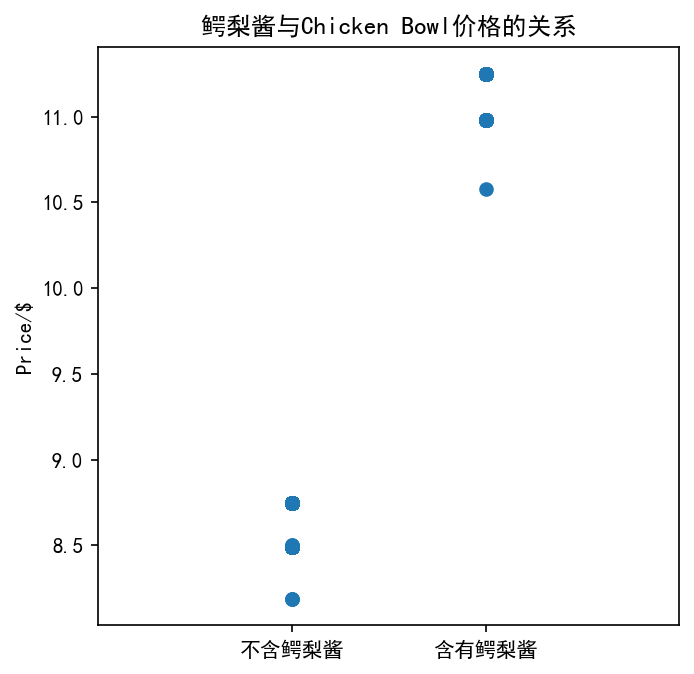

In [63]:
#生成一个新列来表明choice_description中是否含有guacamole

chiken_bowl_1['guacamole'] = chiken_bowl_1.choice_description.apply(lambda x: 1 if isinstance(x, str) and 'Guacamole' in x else 0)

#用散点图画出guacamole与item_price的关系

plt.figure(figsize=(5,5), dpi=150)
plt.scatter(chiken_bowl_1.guacamole, chiken_bowl_1.item_price)
plt.title('鳄梨酱与Chicken Bowl价格的关系')
plt.ylabel("Price/$")
plt.xlim(-1,2)
plt.xticks([0,1], ['不含鳄梨酱', '含有鳄梨酱'])
plt.show()


从上图可以很明显地看出，不含有鳄梨酱的Chicken Bowl价格都在9美元以下，而含有鳄梨酱的Chicken Bowl价格则在10.5美元及以上，有无鳄梨酱是影响商品价格的重要特征。

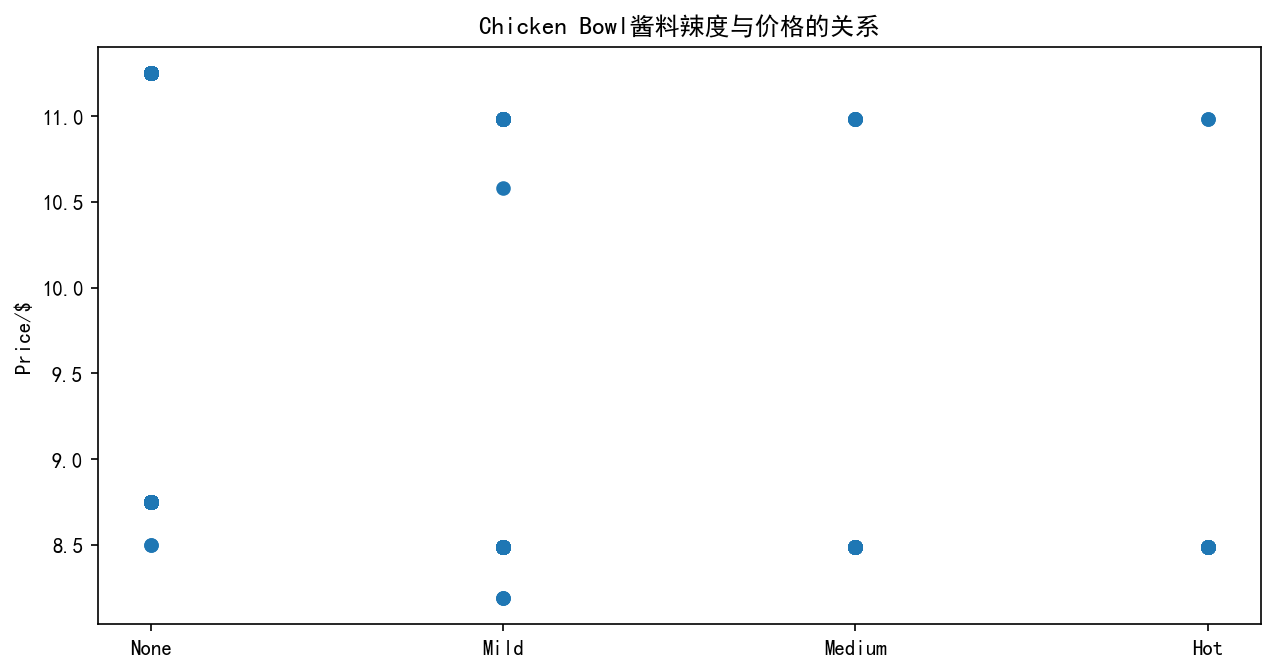

In [61]:
#生成一列来表明chicken bowl的酱料为mild, medium还是hot

chiken_bowl_1['sauce'] = chiken_bowl_1.choice_description.apply(
    lambda x: 1 if 'Mild' in x else (2 if 'Medium' in x else (3 if 'Hot' in x else 0)))

#用散点图画出sauce与item_price的关系

plt.figure(figsize=(10,5), dpi=150)
plt.scatter(chiken_bowl_1.sauce, chiken_bowl_1.item_price)
plt.title('Chicken Bowl酱料辣度与价格的关系')
plt.ylabel("Price/$")
plt.xticks([0,1,2,3], ['None','Mild', 'Medium', 'Hot'])
plt.show()

通过上面的散点图，我们发现不同的酱料辣度选择得到的商品价格是一致的，所以酱料的辣度与Chicken Bowl价格无关。综上所述，配料中是否含有鳄梨酱是Chicken Bowl商品单价波动最主要的影响因子。

### 4.8 使用关联规则分析哪些商品经常被一起购买

In [65]:
#使用mlxtend库对商品进行关联分析

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

#将同一个订单中出现的商品整理成列表的形式
transactions = df.groupby('order_id').item_name.apply(list).tolist()
transactions[:5]

[['Chips and Fresh Tomato Salsa',
  'Izze',
  'Nantucket Nectar',
  'Chips and Tomatillo-Green Chili Salsa'],
 ['Chicken Bowl'],
 ['Chicken Bowl', 'Side of Chips'],
 ['Steak Burrito', 'Steak Soft Tacos'],
 ['Steak Burrito', 'Chips and Guacamole']]

In [74]:
#将列表转换成矩阵
te = TransactionEncoder()
te_ary = te.fit_transform(transactions)
te_df = pd.DataFrame(te_ary, columns=te.columns_)
te_df.head()

,6 Pack Soft Drink,Barbacoa Bowl,Barbacoa Burrito,Barbacoa Crispy Tacos,Barbacoa Salad Bowl,Barbacoa Soft Tacos,Bottled Water,Bowl,Burrito,Canned Soda,...,Steak Crispy Tacos,Steak Salad,Steak Salad Bowl,Steak Soft Tacos,Veggie Bowl,Veggie Burrito,Veggie Crispy Tacos,Veggie Salad,Veggie Salad Bowl,Veggie Soft Tacos
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [81]:
len(transactions),len(te_df)

(1834, 1834)

In [73]:
#计算频繁项集
frequent_itemsets = apriori(te_df, min_support=0.01, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False).head(10)


,support,itemsets
10,0.335333,(Chicken Bowl)
11,0.266630,(Chicken Burrito)
17,0.258451,(Chips and Guacamole)
26,0.186478,(Steak Burrito)
6,0.150491,(Canned Soft Drink)
15,0.113413,(Chips)
25,0.102508,(Steak Bowl)
4,0.083969,(Bottled Water)
55,0.081243,"(Chips and Guacamole, Chicken Bowl)"
53,0.066521,"(Chips, Chicken Bowl)"


In [82]:
#计算关联规则
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values(by=['confidence','lift'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
36,"(Bottled Water, Chips)",(Chicken Bowl),0.019084,0.335333,0.015267,0.800000,2.385691,0.008868,3.323337,0.592135
20,(Chips and Tomatillo Red Chili Salsa),(Chicken Bowl),0.025082,0.335333,0.015812,0.630435,1.880028,0.007402,1.798512,0.480136
42,"(Chips, Canned Soft Drink)",(Chicken Bowl),0.031625,0.335333,0.019084,0.603448,1.799551,0.008479,1.676118,0.458816
18,(Chips),(Chicken Bowl),0.113413,0.335333,0.066521,0.586538,1.749124,0.028490,1.607568,0.483072
4,(Bottled Water),(Chicken Bowl),0.083969,0.335333,0.037623,0.448052,1.336142,0.009465,1.204221,0.274638
37,"(Bottled Water, Chicken Bowl)",(Chips),0.037623,0.113413,0.015267,0.405797,3.578038,0.011000,1.492061,0.748685
12,(Canned Soft Drink),(Chicken Bowl),0.150491,0.335333,0.060523,0.402174,1.199328,0.010059,1.111807,0.195642
2,(6 Pack Soft Drink),(Chips and Guacamole),0.029444,0.258451,0.011450,0.388889,1.504688,0.003841,1.213443,0.345586
11,(Canned Soda),(Steak Burrito),0.051254,0.186478,0.019629,0.382979,2.053751,0.010071,1.318467,0.540805
48,"(Chips and Guacamole, Canned Soft Drink)",(Chicken Bowl),0.033806,0.335333,0.012541,0.370968,1.106268,0.001205,1.056651,0.099421


上表为关联规则中置信度与提升度最高的10组规则。其中规则36，18，4，37表明，Chicken Bowl与瓶装水（Bottled Water）和薯条(Chips)有很高的关联性。

## 5. 结论与建议


+ 考虑到"guacamole"对价格的显著影响，Chipotle可以考虑对这一配料进行更多的营销推广，或提供不同版本的"Chicken Bowl"，以满足不同客户的需求和预算。

+ 针对关联规则分析有如下建议：
    1. **捆绑销售与优惠**：根据经常一起购买的商品组合推出捆绑销售优惠。例如，为经常一起购买的Bottled Water、Chicken Bowl和Chips推出组合套餐优惠。
    2. **商店/餐厅布局优化**：将经常一起购买的商品放在相邻或容易找到的位置，使顾客更容易找到并购买他们需要的商品。
    3. **目标广告与营销**：根据顾客的购买记录，为他们推送相关的广告或优惠券。例如，如果顾客购买了Chicken Bowl，则可以向他们推送Chips和Bottled Water的优惠券。
----------------
+ 为了进一步优化定价策略，建议收集更多关于客户偏好和选择描述的数据，以进行更深入的分析。